In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from preprocessing import convert_month_to_date, group_and_join

/var/folders/vj/mlqyww453lvb1ltc11d9wt140000gn/T/ipykernel_17569/1227346676.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Load Data

In [2]:
target_col = "Country_A_sales_actuals_monthly__vehiclegroup01__orderintake"

In [34]:
df_full = pd.read_csv("../data/kitCapstoneJan24_data.csv", delimiter=";")
df_full = convert_month_to_date(df_full).reset_index()
df_full = group_and_join(df_full, group_by="countryname", join_on="date")
df = df_full.iloc[:276].dropna(axis=1, how="any")

used_columns = df.columns.tolist()

df = df.iloc[:258].copy()
df[target_col] = df_full[target_col]

max_lag = 24
for l in range(1, max_lag + 1):
    col_name = f"{target_col}_lag{l}"
    df[col_name] = df_full[target_col].shift(l)
df = df.iloc[max_lag:]

df.shape

(234, 5453)

# Train Model

In [5]:
X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()
kf = KFold(n_splits=5)

pred = []
scores = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    
    hyperparameters = {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30}
    regressor = RandomForestRegressor(random_state=0, **hyperparameters)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    pred.append(y_pred)

    s = mean_absolute_percentage_error(y_test, y_pred)
    print(f"[fold {i}] MAPE: {s}")
    scores.append(s)
    
pred = np.concatenate(pred)
mean_score = np.mean(scores)
print("MAPE: ", mean_score)

[fold 0] MAPE: 0.29541522398198766
[fold 1] MAPE: 0.2132393739021952
[fold 2] MAPE: 0.2732465484823576
[fold 3] MAPE: 0.418897823541645
[fold 4] MAPE: 0.444236246671074
MAPE:  0.3290070433158519


# Plot Prediction

In [7]:
def scale_prediction(pred, scale):
    return (pred - pred.mean()) * scale + pred.mean()

[Text(0.5, 1.0, 'Order Intakes Country A Model Group 1'),
 Text(0.5, 0, 'month'),
 Text(0, 0.5, 'orders')]

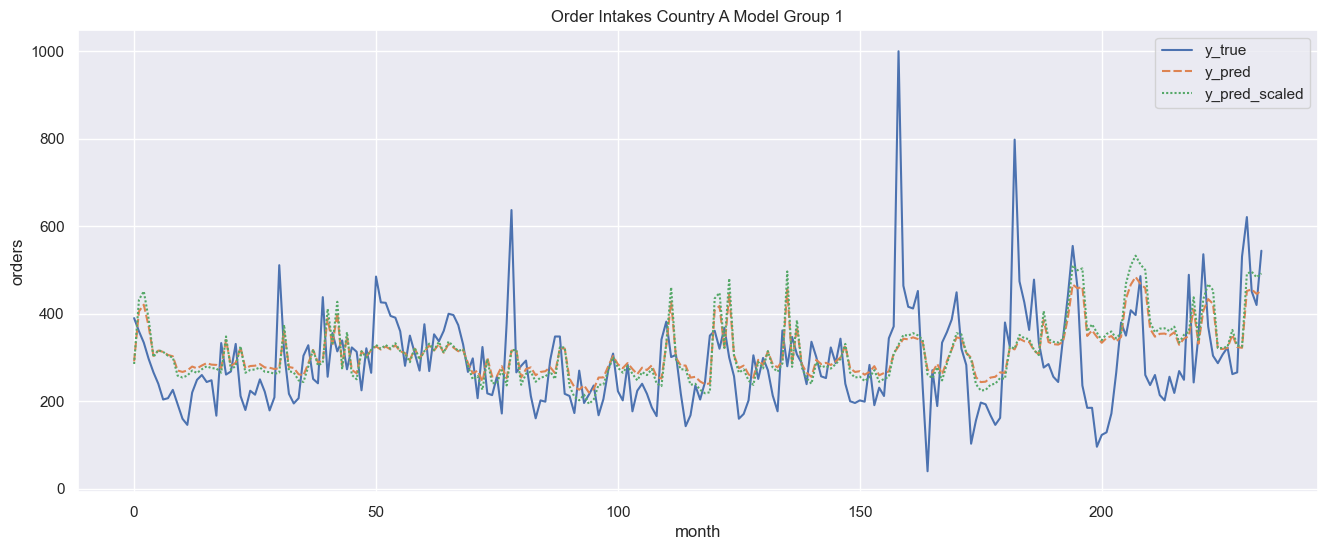

In [8]:
df_result = pd.DataFrame()
df_result["y_true"] = y.to_numpy()
df_result["y_pred"] = pred

SCALE = 1.2828282828282829
df_result["y_pred_scaled"] = scale_prediction(pred, SCALE)

sns.set(rc={'figure.figsize':(16,6)})
ax = sns.lineplot(data=df_result)
ax.set(title="Order Intakes Country A Model Group 1", xlabel="month", ylabel="orders")


# Scaling after Training

In [9]:
def get_mape(df_result, scale):
    df_result = df_result.copy()
    mean = df_result["y_pred"].mean()
    df_result["y_pred_scaled"] = (df_result["y_pred"] - mean) * scale + mean
    return mean_absolute_percentage_error(df_result["y_true"], df_result["y_pred_scaled"])

1.2727272727272727


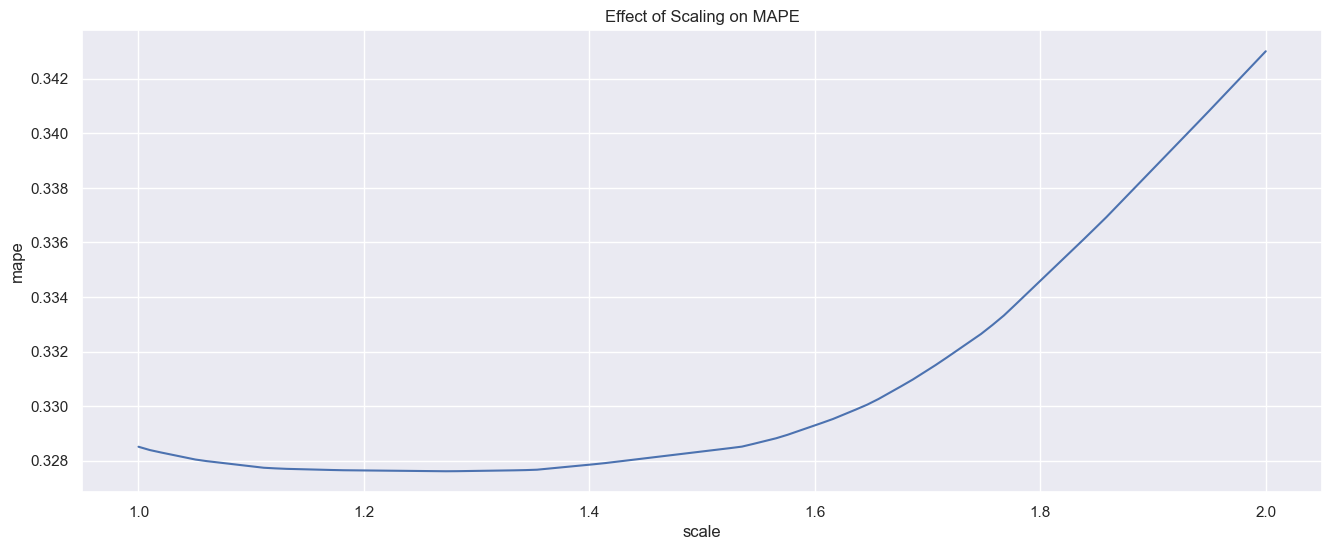

In [10]:
scales = np.linspace(1, 2, 100)
mapes = [get_mape(df_result, s) for s in scales]
ax = sns.lineplot(y = mapes, x = scales)
ax.set(title="Effect of Scaling on MAPE", xlabel="scale", ylabel="mape")

idx_min = np.argmin(mapes)
print(scales[idx_min])

# Plot Feature Importance

In [11]:
def plot_most_important_features(rf_regressor: RandomForestRegressor, top_n=10) -> None:
    fi = pd.DataFrame()
    fi["feature"] = regressor.feature_names_in_
    fi["importance"] = regressor.feature_importances_
    fi = fi.sort_values(by="importance", ascending=False)
    ax = sns.barplot(fi.iloc[:top_n], x="importance", y="feature", orient="y")
    ax.set(title='Feature Importance')
    ax.bar_label(ax.containers[0])

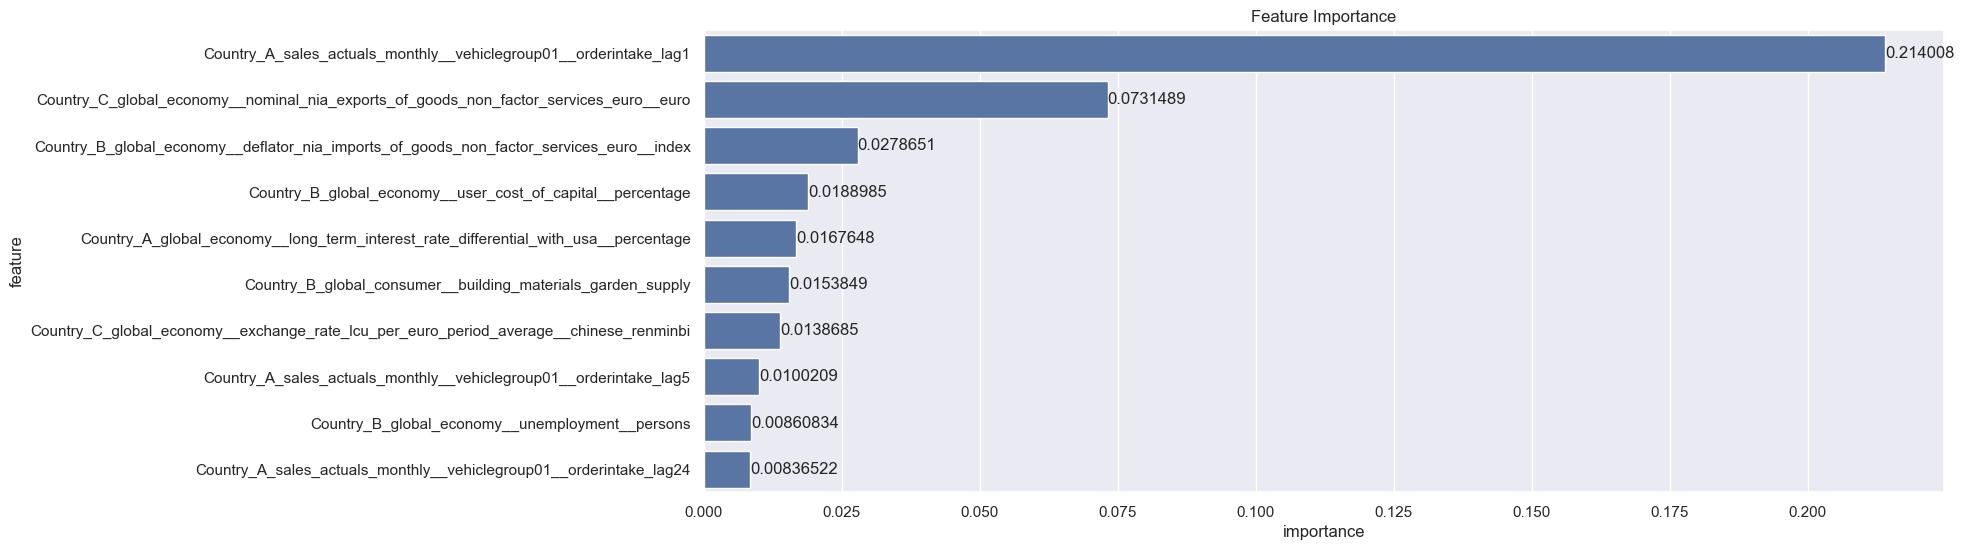

In [12]:
plot_most_important_features(regressor)

# Hyperparameter Optimization

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

regressor = RandomForestRegressor()

random_search = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=param_grid,
    n_iter=10,  # Number of random parameter combinations to try
    scoring="neg_mean_absolute_percentage_error",  # Use MAPE as the metric for optimization
    cv=5,  # 5-fold cross-validation
    random_state=42,
    n_jobs=-1,  # Use all available CPU cores
    verbose=4
)

random_search.fit(X_train, y_train)
print("Best Hyperparameters:", random_search.best_params_)
best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Test MAPE:", mape)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=-0.234 total time=   0.8s
[CV 2/5] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=-0.227 total time=   0.8s
[CV 4/5] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=-0.257 total time=   0.8s
[CV 3/5] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=-0.260 total time=   0.8s
[CV 5/5] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=10;, score=-0.206 total time=   0.8s
[CV 3/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=-0.250 total time=   4.2s
[CV 2/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=-0.226 total time=   4.4s
[CV 1/5] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=-0.224

# Prediction on unknown data

In [13]:
# train on full dataset
X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

hyperparameters = {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30}
regressor = RandomForestRegressor(random_state=0, **hyperparameters)
regressor.fit(X, y)

RandomForestRegressor(max_depth=30, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=400, random_state=0)

In [54]:
# make one-step ahead predictions
prediction_range = list(range(259, 277))

pred = []
for i in prediction_range:
    X_pred = df_full[used_columns].iloc[i:i+1]

    # add lags
    for l in range(1, max_lag + 1):
        col_name = f"{target_col}_lag{l}"
        X_pred[col_name] = df_full[target_col].iloc[i - l]
    p = regressor.predict(X_pred)[0]
    df_full.at[i, target_col] = p
    pred.append(p)

[Text(0.5, 1.0, 'Order Intake Prediction')]

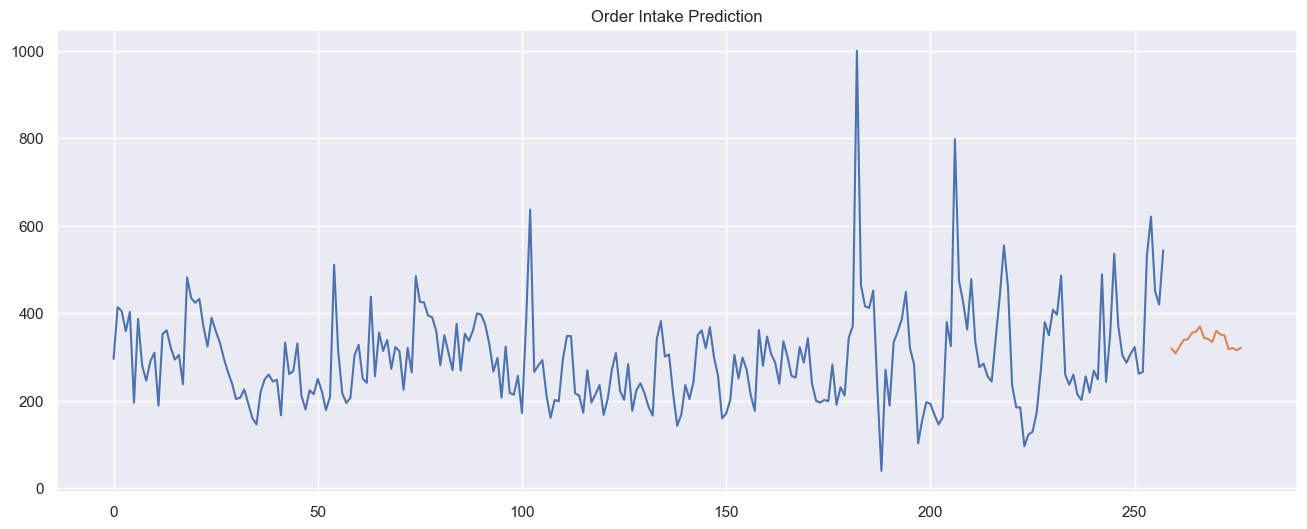

In [70]:
ax = sns.lineplot(df_full[target_col].iloc[train_range].to_numpy())
ax = sns.lineplot(y=pred, x=prediction_range)
ax.set(title="Order Intake Prediction")